## Train a VAE

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


cpu not relevant here
[500, 125, 31, 4]
Epoch: 0, Loss: 40.3697292804718
Epoch: 1, Loss: 39.00453269481659
Epoch: 2, Loss: 38.198583245277405
Epoch: 3, Loss: 37.60185241699219
Epoch: 4, Loss: 37.07188391685486
Epoch: 5, Loss: 36.48355007171631
Epoch: 6, Loss: 35.995776891708374
Epoch: 7, Loss: 35.4049596786499
Epoch: 8, Loss: 34.9353461265564
Epoch: 9, Loss: 34.4344407916069
Epoch: 10, Loss: 33.87390500307083
Epoch: 11, Loss: 33.16110134124756
Epoch: 12, Loss: 32.592224419116974
Epoch: 13, Loss: 32.07969909906387
Epoch: 14, Loss: 31.70951521396637
Epoch: 15, Loss: 31.33249592781067
Epoch: 16, Loss: 31.19753110408783
Epoch: 17, Loss: 31.09170776605606
Epoch: 18, Loss: 30.846536457538605
Epoch: 19, Loss: 30.669292867183685

Invalid parameters: data
Valid parameters are: config
Make plots


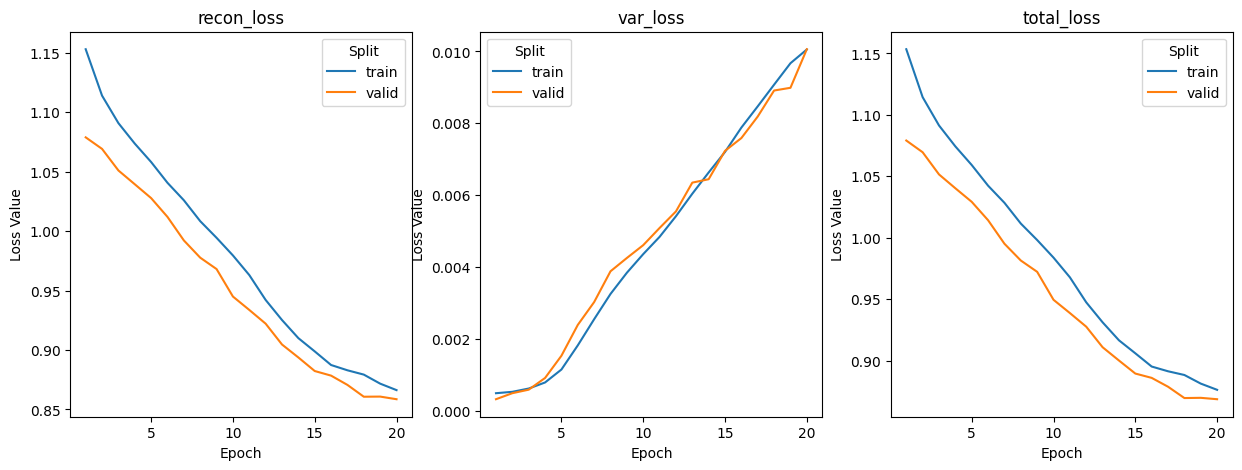

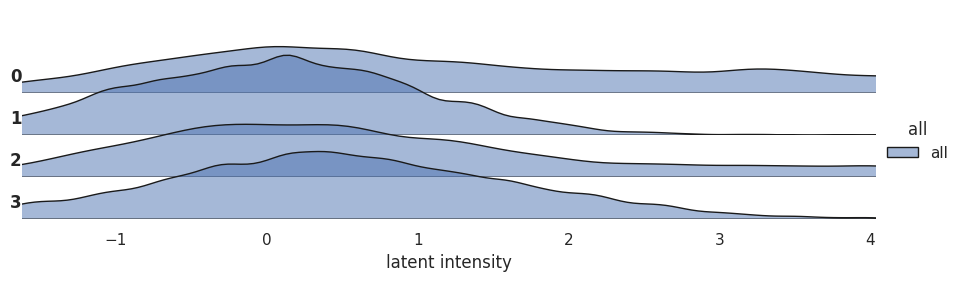

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


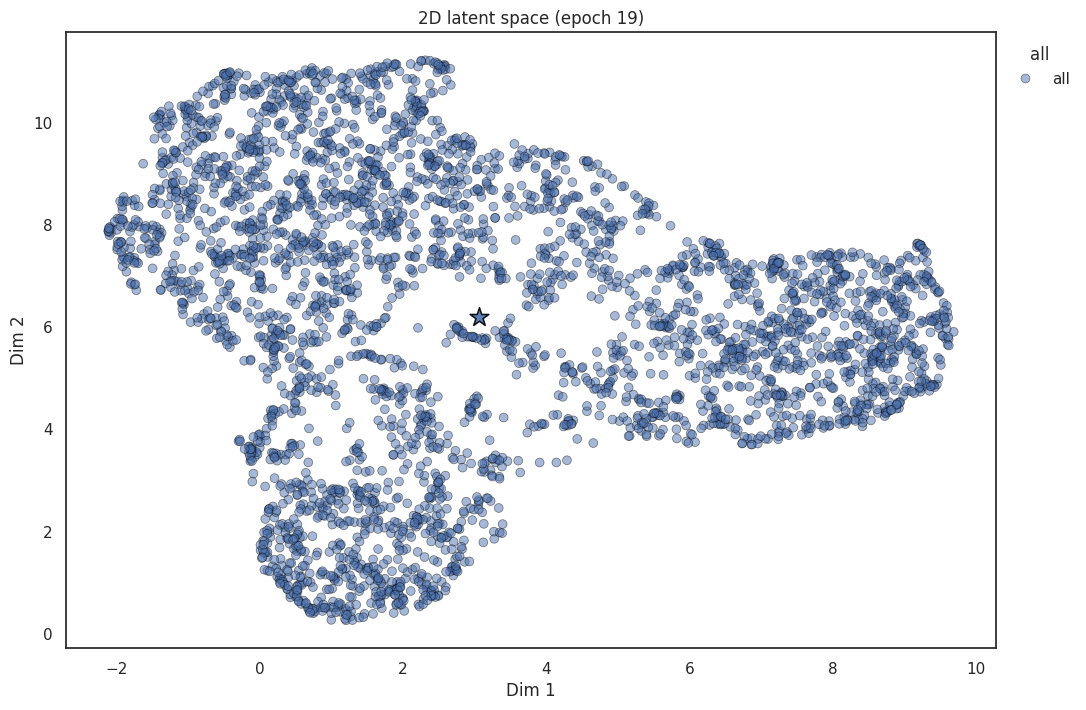

In [1]:
from autoencodix.utils.default_config import DefaultConfig
import autoencodix as acx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


# sample_data = np.random.rand(1000, 100)
sample_data = pd.read_parquet('../data/RNA_data.parquet')
sample_data = sample_data.to_numpy()

my_config = DefaultConfig(learning_rate=0.0001, epochs=20, checkpoint_interval=1, beta=0.01, latent_dim=4,n_layers=2 ,batch_size=64)

custom_train_indices, custom_valid_indices, custom_test_indices = np.split(
	np.arange(len(sample_data)),
	[int(.6*len(sample_data)), int(.8*len(sample_data))])



# the custom split needs to be a dictionary with keys "train", "valid", and "test" and indices of the samples to be included in each split as numpy arrays
custom_split = {
    "train": custom_train_indices,
    "valid": custom_valid_indices,
    "test": custom_test_indices,
}


varix = acx.Varix(data=sample_data, config=my_config, custom_splits=custom_split)
result = varix.run()


## Show 1-3 most relevant plots like loss, latent space, ... 
varix.show_result()


# ## Show specific plot for relative loss contribution
# result.show_loss(type='relative')

# ## Save all plots to a specific directory
# result.save_plots(path='./my_varix_plots/', which='all', format='png')
# which= list(result.plots.keys())
# print(which)


## Getting visualization with Annotation data/param and for specific epoch or split

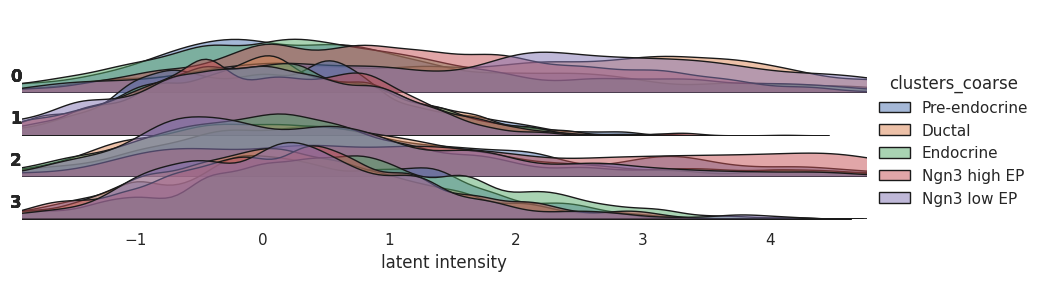

In [2]:
sample_anno= pd.read_parquet('../data/ANNO_data.parquet')

label_list_all = list(sample_anno.iloc[
	np.concatenate((
		custom_train_indices,
		custom_valid_indices,
		custom_test_indices
	), axis=0),:].loc[:,
	'clusters_coarse'])

result.show_latent_space(type="Ridgeline", split='all', label_list=label_list_all, param='clusters_coarse', epoch=15)

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


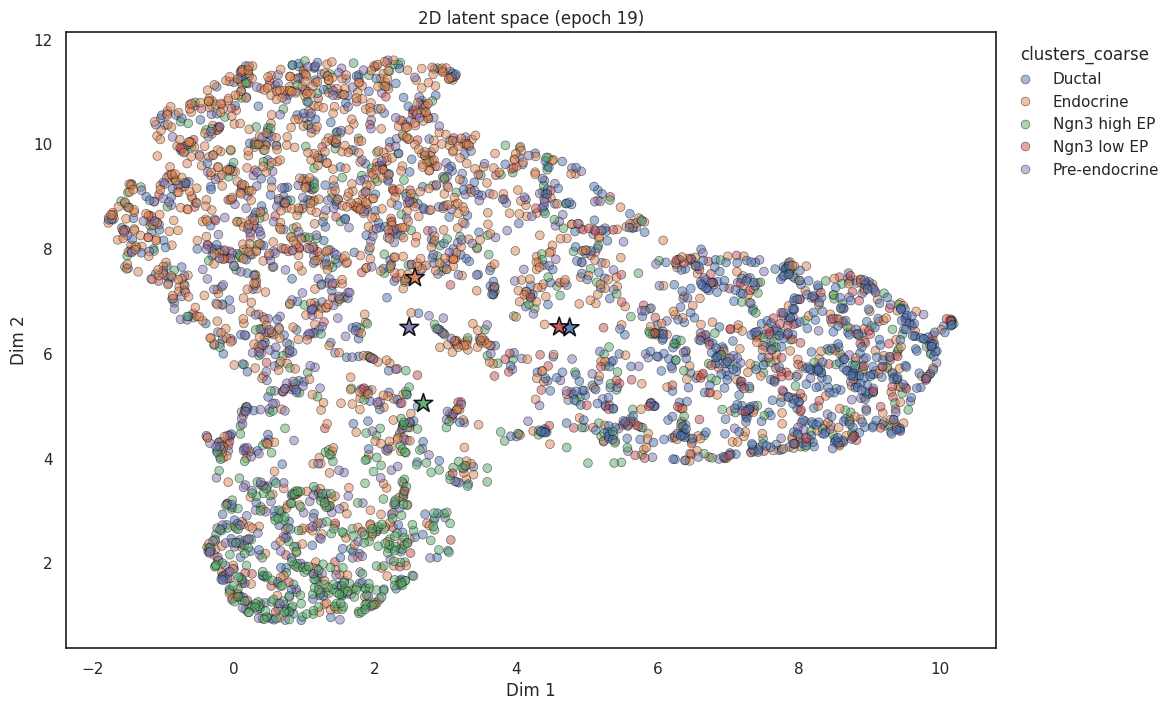

In [3]:
result.show_latent_space(type="2D-scatter", split='all', label_list=label_list_all, param='clusters_coarse')

## Save Plots

In [4]:
result.save_plots(path='./my_varix_plots/', which='all', format='png')

## Loss plot development

In [ ]:
loss_df_melt = pd.DataFrame()

for term in result.sub_losses.keys():
	loss_df = pd.DataFrame.from_dict(
		result.sub_losses.get(key=term).get(),
		orient='index'
		)
	## Make weighting of loss terms 
	if term == "var_loss":
		loss_df = loss_df *  varix.config.beta

	loss_df['Epoch'] = loss_df.index +1
	loss_df['Loss Term'] = term

	# print(loss_df)
	loss_df_melt = pd.concat([	loss_df_melt, 
								loss_df.melt(id_vars=['Epoch','Loss Term'], var_name='Split', value_name='Loss Value')],
								axis=0).reset_index(drop=True)


loss_df = pd.DataFrame.from_dict(
	result.losses.get(),
	orient='index'
		)
loss_df['Epoch'] = loss_df.index +1
loss_df['Loss Term'] = 'total_loss'
loss_df_melt = pd.concat([	loss_df_melt, 
							loss_df.melt(id_vars=['Epoch','Loss Term'], var_name='Split', value_name='Loss Value')],
							axis=0).reset_index(drop=True)
							
loss_df_melt['Loss Value'] = loss_df_melt['Loss Value'].astype(float)

In [ ]:
result.sub_losses.keys()

In [ ]:
my_config.get_params()['beta']

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax = 0

for split in loss_df_melt['Split'].unique():
	sns.lineplot(data=loss_df_melt[(loss_df_melt['Split'] == split)], x="Epoch", y="Loss Value", hue="Loss Term", ax=axes[ax])
	axes[ax].set_title(split)
	ax += 1

# sns.FacetGrid(loss_df_melt, col='Split', hue='Loss Term', height=5).map(sns.lineplot, 'Epoch', 'Loss Value').add_legend()

In [ ]:
exclude = loss_df_melt['Loss Term'] != 'total_loss'

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax = 0

for split in loss_df_melt['Split'].unique():
	sns.kdeplot(data=loss_df_melt[exclude & (loss_df_melt['Split'] == split)], x="Epoch", hue="Loss Term", multiple="fill", weights="Loss Value",clip=[0,30], ax=axes[ax])
	axes[ax].set_title(split)
	ax += 1

## Latent Space visualizations

In [36]:
## from AUTOENCODIX
def plot_latent_ridge(lat_space, label_list=None, param=None, save_fig=""):
    """
    Creates a ridge line plot of latent space dimension where each row shows the density of a latent dimension and groups (ridges).
    ARGS:
        lat_space (pd.DataFrame): DataFrame containing the latent space intensities for samples (rows) and latent dimensions (columns)
        label_list (list): List of labels for each sample. If None, all samples are considered as one group. 
        param (str): Clinical parameter to create groupings and coloring of ridges. Must be a column name (str) of clin_data
        save_fig (str): Path specifying save name and location.
    RETURNS:
        fig (matplotlib.figure): Figure handle (of last plot)
    """
    sns.set_theme(
        style="white", rc={"axes.facecolor": (0, 0, 0, 0)}
    )  ## Necessary to enforce overplotting

    df = pd.melt(lat_space, var_name="latent dim", value_name="latent intensity")
    # df["sample"] = len(lat_space.columns) * list(
    #     lat_space.index.str.removeprefix("FROM_").str.removeprefix("TO_")
    # )
    df["sample"] = len(lat_space.columns) * list(lat_space.index)

    if label_list is None:
        param = "all"
        label_list = ["all"] * len(df)

    # print(labels[0])
    if not (type(label_list[0]) is str):
        if len(np.unique(label_list)) > 3:
            label_list = pd.qcut(
                label_list, q=4, label_list=["1stQ", "2ndQ", f"3rdQ", f"4thQ"]
            ).astype(str)
        else:
            label_list = [str(x) for x in label_list]
    df[param] = len(lat_space.columns) * label_list

    exclude_missing_info = (df[param] == "unknown") | (df[param] == "nan")

    xmin = (
        df.loc[~exclude_missing_info, ["latent intensity", "latent dim", param]]
        .groupby([param, "latent dim"], observed=False)
        .quantile(0.05)
        .min()
    )
    xmax = (
        df.loc[~exclude_missing_info, ["latent intensity", "latent dim", param]]
        .groupby([param, "latent dim"], observed=False)
        .quantile(0.9)
        .max()
    )

    if len(np.unique(df[param])) > 8:
        cat_pal = sns.husl_palette(len(np.unique(df[param])))
    else:
        cat_pal = sns.color_palette(n_colors=len(np.unique(df[param])))

    g = sns.FacetGrid(
        df[~exclude_missing_info],
        row="latent dim",
        hue=param,
        aspect=12,
        height=0.8,
        xlim=(xmin.iloc[0], xmax.iloc[0]),
        palette=cat_pal,
    )

    g.map_dataframe(
        sns.kdeplot,
        "latent intensity",
        bw_adjust=0.5,
        clip_on=True,
        fill=True,
        alpha=0.5,
        warn_singular=False,
        ec="k",
        lw=1,
    )

    def label(data, color, label, text="latent dim"):
        ax = plt.gca()
        label_text = data[text].unique()[0]
        ax.text(
            0.0,
            0.2,
            label_text,
            fontweight="bold",
            ha="right",
            va="center",
            transform=ax.transAxes,
        )

    g.map_dataframe(label, text="latent dim")

    g.set(xlim=(xmin.iloc[0], xmax.iloc[0]))
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    g.add_legend()

    if len(save_fig) > 0:
        g.savefig(save_fig)

    # plt.close()
    return g

In [3]:
sample_anno= pd.read_parquet('../data/ANNO_data.parquet')
print(sample_anno)

sample_rna= pd.read_parquet('../data/RNA_data.parquet')
# sample_rna

                 clusters_coarse       clusters   S_score  G2M_score  \
index                                                                  
AAACCTGAGAGGGATA   Pre-endocrine  Pre-endocrine -0.224902  -0.252071   
AAACCTGAGCCTTGAT          Ductal         Ductal -0.014707  -0.232610   
AAACCTGAGGCAATTA       Endocrine          Alpha -0.171255  -0.286834   
AAACCTGCATCATCCC          Ductal         Ductal  0.599244   0.191243   
AAACCTGGTAAGTGGC    Ngn3 high EP   Ngn3 high EP -0.179981  -0.126030   
...                          ...            ...       ...        ...   
TTTGTCAAGTGACATA   Pre-endocrine  Pre-endocrine -0.235896  -0.266101   
TTTGTCAAGTGTGGCA    Ngn3 high EP   Ngn3 high EP  0.279374  -0.204047   
TTTGTCAGTTGTTTGG          Ductal         Ductal -0.045692  -0.208907   
TTTGTCATCGAATGCT       Endocrine          Alpha -0.240576  -0.206865   
TTTGTCATCTGTTTGT       Endocrine        Epsilon -0.136407  -0.184763   

                  initial_size_unspliced  initial_size_spliced 

## 2D visualization

In [4]:
def plot_2D(
    embedding,
    labels,
    param=None,
    layer="latent space",
    figsize=(24, 15),
    center=True,
    plot_numeric=False,
    save_fig="",
    xlim=None,
    ylim=None,
    scale=None,
    no_leg=False,
):
    """
    Creates a 2D visualization of the 2D embedding of the latent space.
    ARGS:
        embedding (pd.DataFrame): embedding on which is visualized. Assumes prior 2D dimension reduction.
        labels (list): Clinical parameters or cluster labels to colorize samples (points)
        layer (str): Label for plot title to indicate which network layer is represented by UMAP/TSNE
        figsize (tuple): Figure size specification.
        center (boolean): If True (default) centers of clusters/groups are visualized as stars.
        save_fig (str): File path for saving the plot. Use appropriate file
                        endings to specify image type (e.g. '*.png')
    RETURNS:
        fig (matplotlib.figure): Figure handle

    """
       
    numeric = False
    if not (type(labels[0]) is str):
        if len(np.unique(labels)) > 3:
            if not plot_numeric:
                print(
                    f"The provided label column is numeric and converted to categories."
                )
                labels = pd.qcut(
                    labels, q=4, labels=["1stQ", "2ndQ", f"3rdQ", f"4thQ"]
                ).astype(str)
            else:
                center = False  ## Disable centering for numeric params
                numeric = True
        else:
            labels = [str(x) for x in labels]

    fig, ax1 = plt.subplots(figsize=figsize)

    # check if label or embedding is longerm and duplicate the shorter one
    if len(labels) < embedding.shape[0]:
        print(
            "Given labels do not have the same length as given sample size. Labels will be duplicated."
        )
        labels = [
            label for label in labels for _ in range(embedding.shape[0] // len(labels))
        ]
    elif len(labels) > embedding.shape[0]:
        labels = list(set(labels))

    if numeric:
        ax2 = sns.scatterplot(
            x=embedding.iloc[:, 0],
            y=embedding.iloc[:, 1],
            hue=labels,
            palette="bwr",
            s=40,
            alpha=0.5,
            ec="black",
        )
    else:
        ax2 = sns.scatterplot(
            x=embedding.iloc[:, 0],
            y=embedding.iloc[:, 1],
            hue=labels,
            hue_order=np.unique(labels),
            s=40,
            alpha=0.5,
            ec="black",
        )
    if center:
        means = embedding.groupby(by=labels).mean()

        ax2 = sns.scatterplot(
            x=means.iloc[:, 0],
            y=means.iloc[:, 1],
            hue=np.unique(labels),
            hue_order=np.unique(labels),
            s=200,
            ec="black",
            alpha=0.9,
            marker="*",
            legend=False,
            ax=ax2,
        )

    if not xlim == None:
        ax2.set_xlim(xlim[0], xlim[1])

    if not ylim == None:
        ax2.set_ylim(ylim[0], ylim[1])

    if not scale == None:
        plt.yscale(scale)
        plt.xscale(scale)
    ax2.set_xlabel("Dim 1")
    ax2.set_ylabel("Dim 2")
    legend_cols = 1
    if len(np.unique(labels)) > 10:
        legend_cols = 2

    if no_leg:
        plt.legend([], [], frameon=False)
    else:
        sns.move_legend(
            ax2,
            "upper left",
            bbox_to_anchor=(1, 1),
            ncol=legend_cols,
            title=param,
            frameon=False,
        )

    # Add title to the plot
    ax2.set_title(layer)

    if len(save_fig) > 0:
        fig.savefig(save_fig, bbox_inches="tight")
    
    plt.close()
    return fig


In [ ]:
from autoencodix.utils._utils  import show_figure
from umap import UMAP


def show_latent_space(type="2D-scatter", label_list=None, param="all", epoch=None, split="all"):

	if type=="2D-scatter":
		# Set Defaults		
		if epoch is None:
			epoch = varix.config.epochs-1
		
		if split == "all":
			df_latent = pd.DataFrame(
				np.concatenate([
					result.latentspaces.get(epoch=epoch, split='train'),
					result.latentspaces.get(epoch=epoch, split='valid'),
					result.latentspaces.get(epoch=-1, split='test')
					])
				)
		else:
			if split == "test":		
				df_latent = pd.DataFrame(result.latentspaces.get(epoch=-1, split=split))
			else:
				df_latent = pd.DataFrame(result.latentspaces.get(epoch=epoch, split=split))
		
		if label_list is None:
			label_list = ["all"] * df_latent.shape[0]

		## Make 2D Embedding with UMAP
		if df_latent.shape[1] > 2:
			reducer = UMAP(n_components=2)
			embedding = pd.DataFrame(reducer.fit_transform(df_latent))
		else:
			embedding = df_latent

		if 	not result.plots['2D-scatter'][epoch][split][param]:	## Create when not exist
			result.plots['2D-scatter'][epoch][split][param] = plot_2D(
				embedding=embedding,
				labels=label_list,
				param=param,
				layer=f'2D latent space (epoch {epoch})',
				figsize=(12, 8),
				center=True,
				save_fig='',
			)	
			
		fig = result.plots['2D-scatter'][epoch][split][param]	
		show_figure(fig)
		plt.show()
	
	if type=="Ridgeline":
		if epoch is None:
			epoch = varix.config.epochs-1
		
		if split == "all":
			df_latent = pd.DataFrame(
				np.concatenate([
					result.latentspaces.get(epoch=epoch, split='train'),
					result.latentspaces.get(epoch=epoch, split='valid'),
					result.latentspaces.get(epoch=-1, split='test')
					])
				)
		else:
			if split == "test":		
				df_latent = pd.DataFrame(result.latentspaces.get(epoch=-1, split=split))
			else:
				df_latent = pd.DataFrame(result.latentspaces.get(epoch=epoch, split=split))	
		
		if label_list is None:
			label_list = ["all"] * df_latent.shape[0]
		
		## Make ridgeline plot
		if 	not result.plots['Ridgeline'][epoch][split][param]:	## Create when not exist
			result.plots['Ridgeline'][epoch][split][param] = plot_latent_ridge(lat_space=df_latent, label_list=label_list, param=param)
		
		fig = result.plots['Ridgeline'][epoch][split][param].figure
		show_figure(fig)
		plt.show()
	
	if type=="Coverage-Correlation":
		## TODO
		print("Not implemented yet, empty figure will be shown instead")
		fig = plt.figure()
		result.plots['Coverage-Correlation'] = fig
		show_figure(fig)
		plt.show()

	return fig		


In [16]:
del result.plots['Ridgeline'][99]['all']

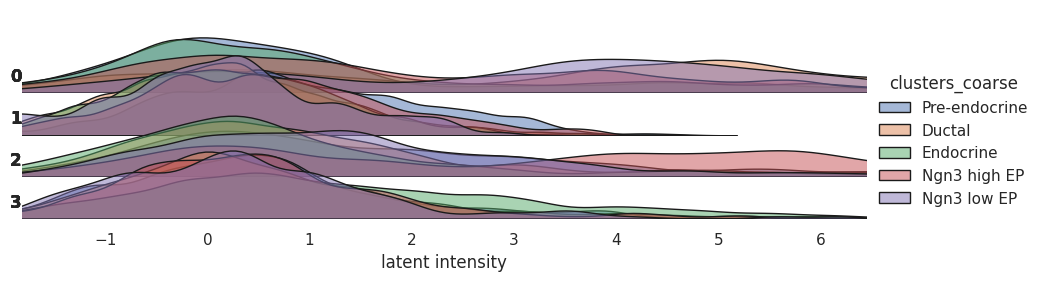

In [25]:
show_latent_space(type="Ridgeline", split='all', label_list=list(sample_anno.loc[:,'clusters_coarse']), param='clusters_coarse', epoch=90)

## Make Animation of latent space evolving over epochs?

In [44]:
# import matplotlib.animation as animation

# # Function to update the ridgeline plot for each epoch
# def update(epoch):
# 	# plt.clf()
# 	g = show_latent_space(type="Ridgeline", split='all', label_list=list(sample_anno.loc[:,'clusters_coarse']), param='clusters_coarse', epoch=epoch)
# 	# plt.title(f'Epoch {epoch}')
# 	plt.close()
# 	return g

# # Create the figure
# fig = plt.figure(figsize=(12, 8))

# # Create the animation
# # ani = animation.FuncAnimation(fig, update, frames=range(varix.config.epochs), repeat=False)
# ani = animation.FuncAnimation(fig, update, frames=range(10), repeat=False)


# # Save the animation as a GIF
# ani.save('ridgeline_animation.gif', writer='imagemagick')

# # Display the animation
# plt.show()

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


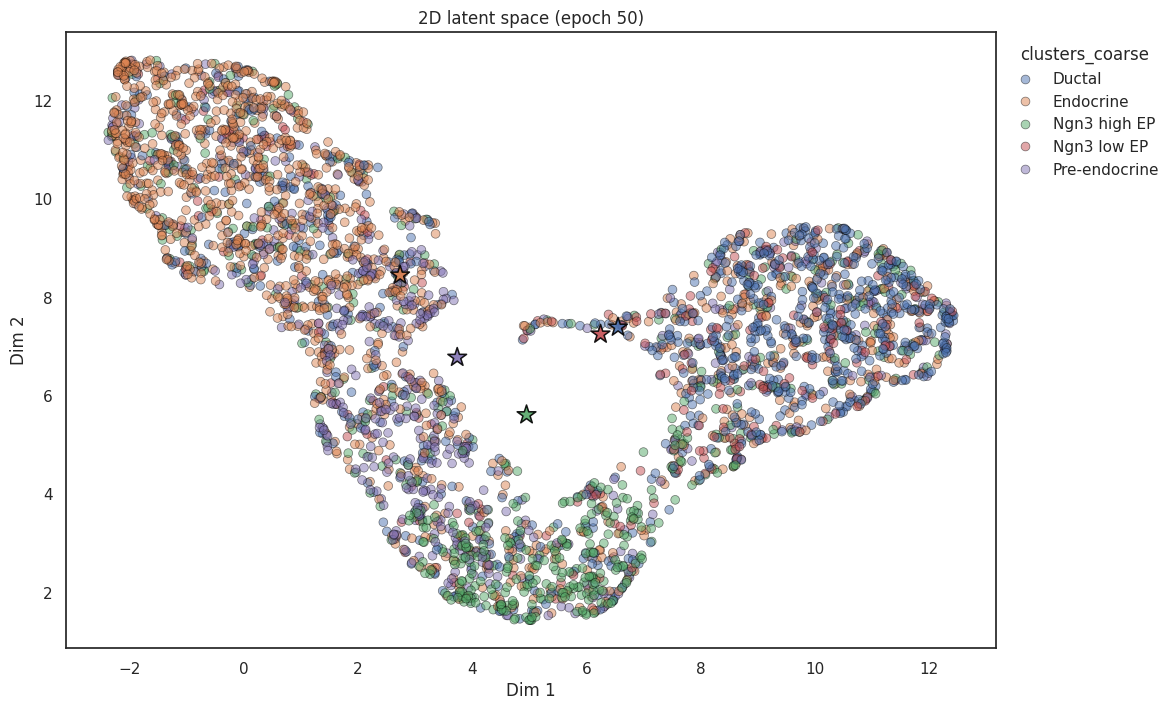

In [19]:
show_latent_space(type="2D-scatter", split='all', label_list=list(sample_anno.loc[:,'clusters_coarse']), param='clusters_coarse', epoch=50)

## UMAP on Input for comparison

In [ ]:
input_embedding = pd.DataFrame(reducer.fit_transform(result.preprocessed_data))
plot_2D(embedding=input_embedding, labels=list(sample_anno.loc[:,'clusters_coarse']), param='clusters_coarse', layer='latent space', figsize=(12, 8), center=True, save_fig='')
